In [1]:
import re
import string
import nltk
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup


# If needed, execute the following
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# pip install wordcloud

In [2]:
msgs = pd.read_csv("spam.csv", encoding='latin1')

In [3]:
msgs

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
msgs.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
# Display rows where any of the columns 'Unnamed: 2', 'Unnamed: 3', or 'Unnamed: 4' are not null
filtered_msgs = msgs[msgs[['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].notna().any(axis=1)]
print(filtered_msgs.head(10))

        v1                                                 v2  \
95    spam  Your free ringtone is waiting to be collected....   
281    ham                                \Wen u miss someone   
444    ham  \HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...   
671   spam         SMS. ac sun0819 posts HELLO:\You seem cool   
710    ham  Height of Confidence: All the Aeronautics prof...   
899   spam  Your free ringtone is waiting to be collected....   
1038   ham  Edison has rightly said, \A fool can ask more ...   
1127   ham  Height of \Oh shit....!!\" situation: A guy th...   
1266   ham    \Hey sorry I didntgive ya a a bellearlier hunny   
1384   ham  Storming msg: Wen u lift d phne, u say \HELLO\...   

                                             Unnamed: 2  \
95                                          PO Box 5249   
281    the person is definitely special for u..... B...   
444    HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...   
671    wanted to say hi. HI!!!\" Stop? Send STOP

In [6]:
msgs.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
msgs

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_words)

# Apply the function to the 'v2' column
msgs['without_stopwords'] = msgs['v2'].apply(remove_stopwords)

# Display to verify the changes
msgs

,v1,v2,without_stopwords
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point, crazy.. Available bugis n great ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,U dun say early hor... U c say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah don't think goes usf, lives"
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u. U won å£750 Pound ...
5568,ham,Will Ì_ b going to esplanade fr home?,Ì_ b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...","Pity, * mood that. So...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,guy did bitching acted like i'd interested buy...


# BASIC EDA (WITHOUT TOKENIZATION)

In [8]:
# Separate the data into ham and spam
ham_words = msgs[msgs['v1'] == 'ham']['without_stopwords'].sum()
spam_words = msgs[msgs['v1'] == 'spam']['without_stopwords'].sum()

# Count the frequency of words
ham_word_freq = Counter(ham_words.split())
spam_word_freq = Counter(spam_words.split())

# Get the 10 most common words for each class
top_10_ham_words = ham_word_freq.most_common(10)
top_10_spam_words = spam_word_freq.most_common(10)

print("Top 10 Ham Words:", top_10_ham_words)
print("Top 10 Spam Words:", top_10_spam_words)

Top 10 Ham Words: [('u', 592), ('2', 274), ('&lt;#&gt;', 242), ('.', 200), ('like', 190), ('ur', 179), ('U', 178), ('got', 176), ('come', 174), ('just', 166)]
Top 10 Spam Words: [('2', 167), ('ur', 100), ('&', 98), ('4', 93), ('mobile', 74), ('claim', 73), ('FREE', 70), ('txt', 67), ('text', 66), ('Txt', 63)]


In [9]:
# Function to generate n-grams
def get_ngrams(text, n):
    words = text.split()
    return list(ngrams(words, n))

# Generate bigrams for ham and spam
ham_bigrams = get_ngrams(ham_words, 2)
spam_bigrams = get_ngrams(spam_words, 2)

# Count the frequency of bigrams
ham_bigram_freq = Counter(ham_bigrams)
spam_bigram_freq = Counter(spam_bigrams)

# Get the 10 most common bigrams for each class
top_10_ham_bigrams = ham_bigram_freq.most_common(10)
top_10_spam_bigrams = spam_bigram_freq.most_common(10)

print("Top 10 Ham Bigrams:", top_10_ham_bigrams,'\n')
print("Top 10 Spam Bigrams:", top_10_spam_bigrams)


Top 10 Ham Bigrams: [(('.', '.'), 67), (('&lt;#&gt;', '.'), 34), (('wan', '2'), 31), (('let', 'know'), 23), (('r', 'u'), 21), (('u', 'r'), 19), (('right', 'now.'), 15), (('time', 'u'), 14), (('Pls', 'send'), 13), (('u', 'wan'), 13)] 

Top 10 Spam Bigrams: [(('å£1000', 'cash'), 19), (('prize', 'GUARANTEED.'), 19), (('2', 'claim'), 17), (('PO', 'Box'), 17), (('Account', 'Statement'), 16), (('land', 'line.'), 16), (('trying', 'contact'), 15), (('draw', 'shows'), 15), (('selected', 'receive'), 15), (('entry', '2'), 14)]


In [10]:
# Generate trigrams for ham and spam
ham_trigrams = get_ngrams(ham_words, 3)
spam_trigrams = get_ngrams(spam_words, 3)

# Count the frequency of trigrams
ham_trigram_freq = Counter(ham_trigrams)
spam_trigram_freq = Counter(spam_trigrams)

# Get the 10 most common trigrams for each class
top_10_ham_trigrams = ham_trigram_freq.most_common(10)
top_10_spam_trigrams = spam_trigram_freq.most_common(10)

print("Top 10 Ham Trigrams:", top_10_ham_trigrams,'\n')
print("Top 10 Spam Trigrams:", top_10_spam_trigrams)


Top 10 Ham Trigrams: [(('.', '.', '.'), 26), (('phone', 'right', 'now.'), 12), (('right', 'now.', 'Pls'), 12), (('now.', 'Pls', 'send'), 12), (('u', 'wan', '2'), 12), (('goes', 'day', '?'), 8), (('U', 'wan', '2'), 7), (('u', 'feel', 'u'), 6), (('x', 'x', 'x'), 6), (('set', 'callertune', 'Callers.'), 5)] 

Top 10 Spam Trigrams: [(('draw', 'shows', 'won'), 14), (('land', 'line.', 'Claim'), 13), (('2003', 'Account', 'Statement'), 13), (('shows', '800', 'un-redeemed'), 12), (('guaranteed', 'å£1000', 'cash'), 10), (('draw', 'txt', 'MUSIC'), 9), (('800', 'un-redeemed', 'S.'), 9), (('un-redeemed', 'S.', 'I.'), 9), (('S.', 'I.', 'M.'), 9), (('I.', 'M.', 'points.'), 9)]


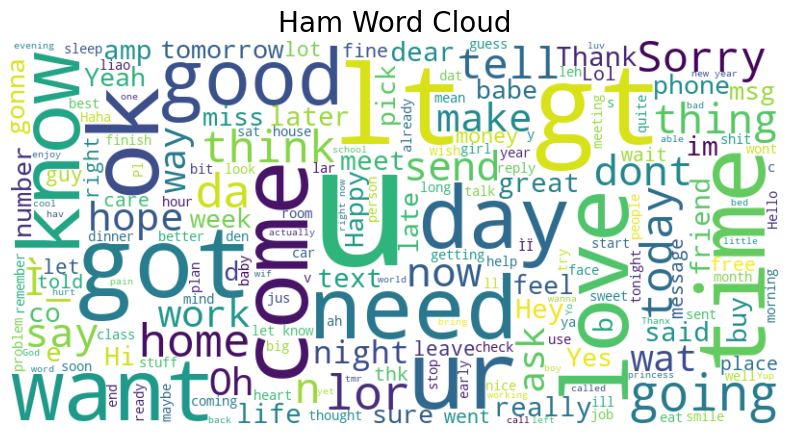

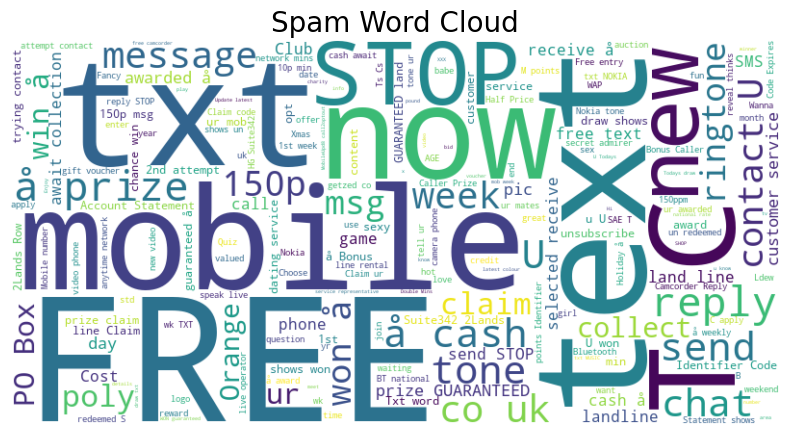

In [11]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Generate word cloud for ham and spam
generate_wordcloud(ham_words, 'Ham Word Cloud')
print("\n")
generate_wordcloud(spam_words, 'Spam Word Cloud')

# BAG-OF-WORDS WITHOUT PREPROCESSING

In [12]:
# Initialize the CountVectorizers
vectorizer = CountVectorizer()

# Fit and transform the text without stopwords (or raw text data)
X = vectorizer.fit_transform(msgs['without_stopwords'])

# vectorizer2 = CountVectorizer()
# X2 = vectorizer2.fit_transform(msgs['v2'])

# Convert to array for easy visualization
X_array = X.toarray()
# X2_array = X2.toarray()

# Get the feature names (vocabulary)
vocab = vectorizer.get_feature_names_out()
# vocab2 = vectorizer2.get_feature_names_out()

# Create a DataFrame for better visualization
vectorized_df = pd.DataFrame(X_array, columns=vocab)
# vectorized_df_2 = pd.DataFrame(X2_array, columns=vocab2)

print("VECTORIZATION OF TEXT DATA WITHOUT STOP WORDS")
print("Vocabulary:", vocab)
print("Document Vectors:\n", vectorized_df)

# print("\n")

# print("VECTORIZATION OF RAW TEXT DATA")
# print("Vocabulary:", vocab2)
# print("Document Vectors:\n", vectorized_df_2)

VECTORIZATION OF TEXT DATA WITHOUT STOP WORDS
Vocabulary: ['00' '000' '000pes' ... 'ûïharry' 'ûò' 'ûówell']
Document Vectors:
       00  000  000pes  008704050406  0089  0121  01223585236  01223585334  \
0      0    0       0             0     0     0            0            0   
1      0    0       0             0     0     0            0            0   
2      0    0       0             0     0     0            0            0   
3      0    0       0             0     0     0            0            0   
4      0    0       0             0     0     0            0            0   
...   ..  ...     ...           ...   ...   ...          ...          ...   
5567   0    0       0             0     0     0            0            0   
5568   0    0       0             0     0     0            0            0   
5569   0    0       0             0     0     0            0            0   
5570   0    0       0             0     0     0            0            0   
5571   0    0       0     

# MODEL FITTING (USING BAG-OF-WORDS VECTORS)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, msgs['v1'], test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred, pos_label='spam')

print("F1-Score using Bag-of-Words:", f1)

F1-Score using Bag-of-Words: 0.9051094890510949


# MODEL FITTING (USING Tf-IDF VECTORS)

In [14]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text without stopwords (or raw text data)
X_tfidf = tfidf_vectorizer.fit_transform(msgs['without_stopwords'])

# Convert to array for easy visualization (if needed)
X_tfidf_array = X_tfidf.toarray()

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_array, msgs['v1'], test_size=0.2, random_state=42)

# Initialize new Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_tfidf = model.predict(X_test_tfidf)

# Calculate the F1-score
f1_tfidf = f1_score(y_test, y_pred_tfidf, pos_label='spam')

print("F1-Score using TF-IDF:", f1_tfidf)

F1-Score using TF-IDF: 0.769230769230769


# PREPROCESSING

In [15]:
print("Number of identical rows =",len(msgs[msgs.duplicated()]))

Number of identical rows = 403


In [16]:
msgs = msgs.drop_duplicates().reset_index(drop=True)
print("Number of identical rows =",len(msgs[msgs.duplicated()]))
msgs

Number of identical rows = 0


,v1,v2,without_stopwords
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point, crazy.. Available bugis n great ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,U dun say early hor... U c say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah don't think goes usf, lives"
...,...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u. U won å£750 Pound ...
5165,ham,Will Ì_ b going to esplanade fr home?,Ì_ b going esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s...","Pity, * mood that. So...any suggestions?"
5167,ham,The guy did some bitching but I acted like i'd...,guy did bitching acted like i'd interested buy...


In [17]:
# Define the text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove HTML tags using html.parser explicitly
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to the text data
msgs['preprocessed_text'] = msgs['v2'].apply(preprocess_text)

# Display dataframe with added column
msgs

C:\Users\suchi\AppData\Local\Temp\ipykernel_34792\1180046539.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,v1,v2,without_stopwords,preprocessed_text
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point, crazy.. Available bugis n great ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,U dun say early hor... U c say...,u dun say early hor u c say
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah don't think goes usf, lives",nah dont think go usf life
...,...,...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u. U won å£750 Pound ...,nd time tried contact u u won å£ pound prize c...
5165,ham,Will Ì_ b going to esplanade fr home?,Ì_ b going esplanade fr home?,ì b going esplanade fr home
5166,ham,"Pity, * was in mood for that. So...any other s...","Pity, * mood that. So...any suggestions?",pity mood soany suggestion
5167,ham,The guy did some bitching but I acted like i'd...,guy did bitching acted like i'd interested buy...,guy did bitching acted like id interested buyi...


# BASIC EDA (WITH PREPROCESSED TEXT)

In [18]:
# Separate the data into ham and spam
ham_prepro_words = msgs[msgs['v1'] == 'ham']['preprocessed_text'].sum()
spam_prepro_words = msgs[msgs['v1'] == 'spam']['preprocessed_text'].sum()

# Count the frequency of words
ham_prepro_word_freq = Counter(ham_prepro_words.split())
spam_prepro_word_freq = Counter(spam_prepro_words.split())

# Get the 10 most common words for each class
top_10_ham_prepro_words = ham_prepro_word_freq.most_common(10)
top_10_spam_prepro_words = spam_prepro_word_freq.most_common(10)

print("Top 10 Ham Words:", top_10_ham_prepro_words)
print("Top 10 Spam Words:", top_10_spam_prepro_words)

Top 10 Ham Words: [('u', 741), ('im', 293), ('just', 206), ('got', 193), ('ur', 188), ('like', 183), ('know', 174), ('dont', 170), ('ill', 167), ('come', 162)]
Top 10 Spam Words: [('å£', 210), ('free', 147), ('txt', 123), ('text', 114), ('u', 107), ('mobile', 107), ('ur', 99), ('claim', 93), ('stop', 82), ('reply', 81)]


In [19]:
# Generate bigrams for ham and spam
ham_prepro_bigrams = get_ngrams(ham_prepro_words, 2)
spam_prepro_bigrams = get_ngrams(spam_prepro_words, 2)

# Count the frequency of bigrams
ham_prepro_bigram_freq = Counter(ham_prepro_bigrams)
spam_prepro_bigram_freq = Counter(spam_prepro_bigrams)

# Get the 10 most common bigrams for each class
top_10_ham_prepro_bigrams = ham_prepro_bigram_freq.most_common(10)
top_10_spam_prepro_bigrams = spam_prepro_bigram_freq.most_common(10)

print("Top 10 Ham Bigrams:", top_10_ham_prepro_bigrams,'\n')
print("Top 10 Spam Bigrams:", top_10_spam_prepro_bigrams)


Top 10 Ham Bigrams: [(('gon', 'na'), 48), (('let', 'know'), 32), (('u', 'r'), 29), (('u', 'wan'), 25), (('wan', 'na'), 23), (('r', 'u'), 23), (('new', 'year'), 23), (('lor', 'u'), 15), (('im', 'going'), 15), (('im', 'gon'), 14)] 

Top 10 Spam Bigrams: [(('å£', 'prize'), 39), (('å£', 'cash'), 36), (('won', 'å£'), 29), (('po', 'box'), 23), (('contact', 'u'), 21), (('prize', 'guaranteed'), 20), (('awarded', 'å£'), 19), (('win', 'å£'), 17), (('selected', 'receive'), 16), (('land', 'line'), 16)]


In [20]:
# Generate trigrams for ham and spam
ham_prepro_trigrams = get_ngrams(ham_prepro_words, 3)
spam_prepro_trigrams = get_ngrams(spam_prepro_words, 3)

# Count the frequency of trigrams
ham_prepro_trigram_freq = Counter(ham_prepro_trigrams)
spam_prepro_trigram_freq = Counter(spam_prepro_trigrams)

# Get the 10 most common trigrams for each class
top_10_ham_prepro_trigrams = ham_prepro_trigram_freq.most_common(10)
top_10_spam_prepro_trigrams = spam_prepro_trigram_freq.most_common(10)

print("Top 10 Ham Trigrams:", top_10_ham_prepro_trigrams,'\n')
print("Top 10 Spam Trigrams:", top_10_spam_prepro_trigrams)


Top 10 Ham Trigrams: [(('im', 'gon', 'na'), 14), (('happy', 'new', 'year'), 9), (('hi', 'hi', 'hi'), 6), (('wat', 'time', 'u'), 6), (('x', 'x', 'x'), 6), (('love', 'go', 'day'), 5), (('hope', 'u', 'r'), 4), (('dun', 'disturb', 'u'), 4), (('u', 'wan', 'na'), 4), (('come', 'n', 'pick'), 4)] 

Top 10 Spam Trigrams: [(('å£', 'prize', 'guaranteed'), 19), (('won', 'å£', 'prize'), 16), (('draw', 'show', 'won'), 13), (('show', 'won', 'å£'), 13), (('account', 'statement', 'show'), 13), (('statement', 'show', 'unredeemed'), 13), (('prize', 'guaranteed', 'land'), 13), (('guaranteed', 'land', 'line'), 13), (('land', 'line', 'claim'), 12), (('å£', 'cash', 'å£'), 11)]


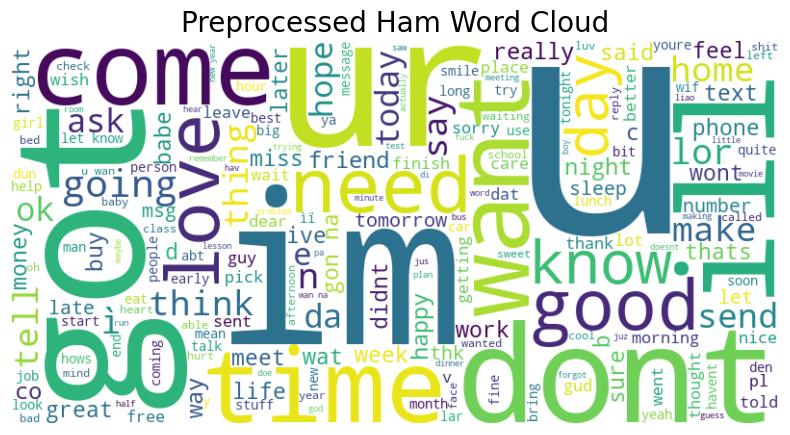

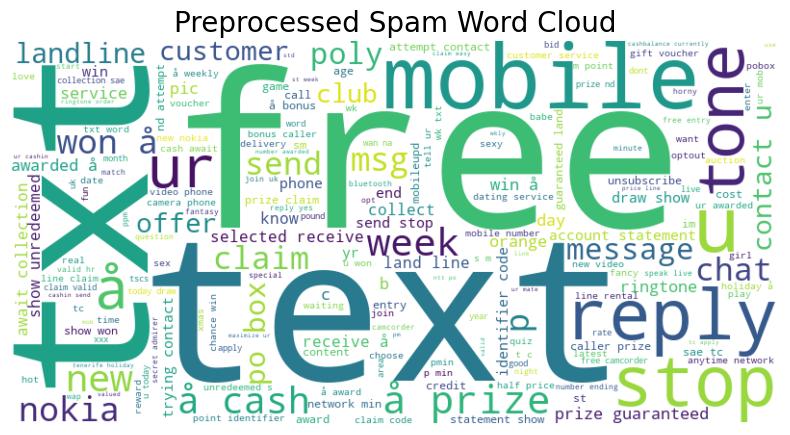

In [21]:
# Generate word cloud for ham and spam
generate_wordcloud(ham_prepro_words, 'Preprocessed Ham Word Cloud')
print("\n")
generate_wordcloud(spam_prepro_words, 'Preprocessed Spam Word Cloud')

# MODEL FITTING (USING Tf-IDF VECTORS OF PREPROCESSED TEXT)

In [22]:
# Initialize the TfidfVectorizer
tfidf_vectorizer_preprocessed = TfidfVectorizer()

# Fit and transform the preprocessed text data
X_tfidf_preprocessed = tfidf_vectorizer_preprocessed.fit_transform(msgs['preprocessed_text'])

# Convert to array for easy visualization (if needed)
X_tfidf_preprocessed_array = X_tfidf_preprocessed.toarray()

# Split the data into training and testing sets
X_train_tfidf_preprocessed, X_test_tfidf_preprocessed, y_train, y_test = train_test_split(X_tfidf_preprocessed_array, msgs['v1'], test_size=0.2, random_state=42)

# Train the model
model.fit(X_train_tfidf_preprocessed, y_train)

# Make predictions
y_pred_tfidf_preprocessed = model.predict(X_test_tfidf_preprocessed)

# Calculate the F1-score
f1_tfidf_preprocessed = f1_score(y_test, y_pred_tfidf_preprocessed, pos_label='spam')

print("F1-Score using TF-IDF with Preprocessing:", f1_tfidf_preprocessed)

F1-Score using TF-IDF with Preprocessing: 0.752136752136752


# SUMMARY OF F1 SCORES

In [23]:
# Summary of F1-scores
f1_scores = {
    'Bag-of-Words': f1,
    'TF-IDF': f1_tfidf,
    'TF-IDF with Preprocessing': f1_tfidf_preprocessed
}

print("Summary of F1-Scores:")
for method, score in f1_scores.items():
    print(f"{method}: {score}")

Summary of F1-Scores:
Bag-of-Words: 0.9051094890510949
TF-IDF: 0.769230769230769
TF-IDF with Preprocessing: 0.752136752136752
